# Figure 3C & S4B

# Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from sympy import symbols, solve, simplify
import pandas as pd
from scipy.optimize import curve_fit
import sympy as sp
plt.rcParams.update({'font.size': 20})

# Definitions

Function to define the properties of the axis of a plot

In [2]:
def my_axsis(ax, xlim, ylim, xticks, title, xtickslabels, bold=True, scale='lin'):    
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks(xticks)
    ax.set_title(title)
    ax.set_xticklabels(xtickslabels)
    
    if bold==True:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(1.2)
            
    if scale=='log':
        ax.set_yscale('log', base=2)

Function to define the properties of the errorbar

In [3]:
def myErrorbar(x, mean_a65, mean_a66, mean_a67, mean_a68, std_a65, std_a66, std_a67, std_a68, axs): 
    axs.errorbar(x, mean_a65, std_a65, label='Exp data (mean \u00B1 std)', marker='o',markersize=5,color='mediumorchid', capsize=5,mfc='mediumorchid', mec='mediumorchid', ls='none', zorder=2)
    axs.errorbar(x, mean_a66, std_a66, label='Exp data (mean \u00B1 std)', marker='o',markersize=5,color='tab:green', capsize=5,mfc='tab:green', mec='tab:green', ls='none', zorder=2)
    axs.errorbar(x, mean_a67, std_a67, label='Exp data (mean \u00B1 std)', marker='o',markersize=5,color='tab:blue', capsize=5,mfc='tab:blue', mec='tab:blue', ls='none', zorder=2)
    axs.errorbar(x, mean_a68, std_a68, label='Exp data (mean \u00B1 std)', marker='o',markersize=5,color='grey', capsize=5,mfc='grey', mec='grey', ls='none', zorder=2)

# Model 

Definition of the parameters of the model

In [4]:
T, V1, V2, K1, K2, Kb = symbols('T V1 V2 K1 K2 Kb') 
Vs, Rb, Ks, Vrg, Qb, Krg = symbols('Vs Rb Ks Vrg Qb Krg')
R, F, Kd, Q, E, Ke = symbols('R F Kd Q E Ke')
S1, Qtot, S2, Rtot= symbols('S1 Qtot S2 Rtot')
Ap,kMM3,Er,KMM3,vMM4,KMM4 = symbols('Ap kMM3 Er KMM3 vMM4 KMM4')
I, kMM1, Er, KMM1, vMM2,KMM2 = symbols('I kMM1 Er KMM1 vMM2 KMM2')
vb, vo, Ap, Ka, Ki, I, k, O = symbols('vb vo Ap Ka Ki I k O')

Evolution equation for T

In [5]:
# Evolution equation for T: 
expr = V1*(1-T)/(K1+(1-T))-V2*T/(K2+T)-Kb*T
expr_simplified= V1*(1-T)*(K2+T) -V2*T*(K1+(1-T))-Kb*T*(K1+(1-T))*(K2+T)
print('Evolution equation for T:')
print(expr)

# Substitute the expression for V1 and V2 in the evolution equation for T:  
expr_RQ= expr_simplified.subs([(V1, Vs*(R*F/(Kd+F))/(Ks+(R*F/(Kd+F)))),(V2, Vrg*(Q*E/(Ke+E))/(Krg+(Q*E/(Ke+E))))])

# Substitute the expressions for Q and R
expr_S1S2 = expr_RQ.subs([(R, Rtot*S1),(Q, Qtot*S2)])

# Expliciting the relation between S1 and S2 to obtain T(FGF, S1): 
expr_T = expr_S1S2.subs([(S2,-1.1265*S1 +0.9092)])

print('Evolution equation for T (all parameters explicited):')
print(expr_T)

# Solve the equation 
sol = solve(expr_T, T)[2]

Evolution equation for T:
-Kb*T - T*V2/(K2 + T) + V1*(1 - T)/(K1 - T + 1)
Evolution equation for T (all parameters explicited):
-E*Qtot*T*Vrg*(0.9092 - 1.1265*S1)*(K1 - T + 1)/((E + Ke)*(E*Qtot*(0.9092 - 1.1265*S1)/(E + Ke) + Krg)) + F*Rtot*S1*Vs*(1 - T)*(K2 + T)/((F + Kd)*(F*Rtot*S1/(F + Kd) + Ks)) - Kb*T*(K2 + T)*(K1 - T + 1)


Definition of the function ExprT that compute T as a function of all the parameters of the equation

In [6]:
def exprT(Vs_v=1, Vrg_v=0.4, K1_v=0.5, K2_v=0.2, Krg_v=1200, Ks_v=1200, Kb_v=0.2, F_v=5, Kd_v=25, E_v=5, Ke_v=50, Rtot_v=2000, Qtot_v=2000, S1_v=0.5):
    sol_T = sol.subs([(Vs,Vs_v),(Vrg,Vrg_v),(K1, K1_v),(K2,K2_v),(Krg, Krg_v), (Ks, Ks_v), (Kb, Kb_v),(F, F_v),(Kd, Kd_v),(E,E_v), (Ke, Ke_v),(Rtot, Rtot_v),(Qtot,Qtot_v),(S1,S1_v)])
    sol_T = np.real(np.array(sol_T,complex))
    return sol_T

Definition of the function to compute Erk (as a function of T)

In [7]:
def Erk(T,n=2, Kerk=0.5, Erk_max=1, Erk_bas=0): 
    Erk = [ Erk_max* T[i]**n/(T[i]**n +Kerk**n)+Erk_bas for i in range(len(T)) ]
    return Erk

Evolution equation for the activator Ap

In [8]:
expr_Ap = kMM3*Er*(1-Ap)/(KMM3+(1-Ap))-vMM4*Ap/(KMM4+Ap)
sol_Ap= solve(expr_Ap, Ap)[1] 

# Function to compute Ap as a function of the other parameters:  
def exprAp(kMM3_v=12,Er_v=0.5,KMM3_v=0.05,vMM4_v=1,KMM4_v=0.05):
    solAp= sol_Ap.subs([(kMM3,kMM3_v), (Er,Er_v), (KMM4,KMM4_v), (vMM4,vMM4_v), (KMM3,KMM3_v)]) 
    return solAp

Evolution equation for the inhibitor I

In [9]:
expr_I = -kMM1*Er*I/(KMM1+I)+vMM2*(1-I)/(KMM2+(1-I))
sol_I= solve(expr_I, I)[0] 

# Function to compute I as a function of the other parameters: 
def exprI(kMM1_v=12,Er_v=0.5,KMM1_v=0.05,vMM2_v=1,KMM2_v=0.05): 
    solI= sol_I.subs([(kMM1,kMM1_v), (Er,Er_v), (KMM1,KMM1_v), (vMM2,vMM2_v), (KMM2,KMM2_v)]) 
    return solI 

Compute Otx and define a function ExprOtx that compute Otx as a function of all the parameters of the equation

In [10]:
expr_Otx = vb+ vo*Ap/((Ka*(1+I/Ki))+Ap)-k*O
sol_Otx= solve(expr_Otx, O)[0]  

# Function to compute Otx as a function of the other parameters
def exprOtx(Ap_v, I_v, vb_v=0.001,vo_v=1,Ka_v=0.1,Ki_v=0.1,k_v=0.2, Omax=1, Obas=0): 
    solOtx= [sol_Otx.subs([(Ap, Ap_v[i]), (I, I_v[i]), (vb,vb_v), (vo,vo_v), (Ka,Ka_v), (Ki,Ki_v), (k,k_v)])*Omax +Obas for i in range(len(Ap_v))] 
    return solOtx

# Import the experimental data and reproduce the figures of the paper

In [11]:
#read the excel file with the experimental data
data_S1 = pd.read_excel('./ExpData.xlsx', sheet_name='Cell surface contacts')
df_S1 = pd.DataFrame(data_S1)

data_Fig3C = pd.read_excel('./ExpData.xlsx', sheet_name='Fig 3C & S4B')
df_Fig3C = pd.DataFrame(data_Fig3C)

Experimental data figure 1C

In [12]:
# Reltive area of cell surface contact with FGF expressing cells (divided by cell type)
a65_RelContactArea_A = np.array(df_S1['a6.5 S1'].values.tolist())[0:25] 
a66_RelContactArea_A = np.array(df_S1['a6.6 S1'].values.tolist())[0:25] 
a67_RelContactArea_A = np.array(df_S1['a6.7 S1'].values.tolist())[0:25] 
a68_RelContactArea_A = np.array(df_S1['a6.8 S1'].values.tolist())[0:25] 

Experimental data figure 3C

In [13]:
# Level of Otx expression in the different condition
control = np.array(df_Fig3C['Ctrl'].values.tolist())
NVP = np.array(df_Fig3C['nvp'].values.tolist())
Rescue = np.array(df_Fig3C['Rescue'].values.tolist())

# Control: Divide the data per cell type
control_a65 = control[0:16]
control_a66 = control[16:32]
control_a67 = control[32:48]
control_a68 = control[48:64]

# Control: compute the mean and std
mean_Otx_a65 = np.nanmean(control_a65)
mean_Otx_a66 = np.nanmean(control_a66)
mean_Otx_a67 = np.nanmean(control_a67)
mean_Otx_a68 = np.nanmean(control_a68)

std_Otx_a65 = np.nanstd(control_a65)
std_Otx_a66 = np.nanstd(control_a66)
std_Otx_a67 = np.nanstd(control_a67)
std_Otx_a68 = np.nanstd(control_a68)

mean_control = [mean_Otx_a65, mean_Otx_a66, mean_Otx_a67, mean_Otx_a68]
std_control = [std_Otx_a65, std_Otx_a66, std_Otx_a67, std_Otx_a68]


# NVP: Divide the data per cell type
NVP_a65 = NVP[0:16]
NVP_a66 = NVP[16:32]
NVP_a67 = NVP[32:48]
NVP_a68 = NVP[48:64]

# NVP: compute the mean and std
mean_Otx_a65_NVP = np.nanmean(NVP_a65)
mean_Otx_a66_NVP = np.nanmean(NVP_a66)
mean_Otx_a67_NVP = np.nanmean(NVP_a67)
mean_Otx_a68_NVP = np.nanmean(NVP_a68)

std_Otx_a65_NVP = np.nanstd(NVP_a65)
std_Otx_a66_NVP = np.nanstd(NVP_a66)
std_Otx_a67_NVP = np.nanstd(NVP_a67)
std_Otx_a68_NVP = np.nanstd(NVP_a68)

mean_NVP = [mean_Otx_a65_NVP, mean_Otx_a66_NVP, mean_Otx_a67_NVP, mean_Otx_a68_NVP]
std_NVP = [std_Otx_a65_NVP, std_Otx_a66_NVP, std_Otx_a67_NVP, std_Otx_a68_NVP]

# NVP + U0126: compute the mean and std
Rescue_a65 = Rescue[0:16]
Rescue_a66 = Rescue[16:32]
Rescue_a67 = Rescue[32:48]
Rescue_a68 = Rescue[48:64]

# NVP +U0126: compute the mean and std
mean_Otx_a65_Rescue = np.nanmean(Rescue_a65)
mean_Otx_a66_Rescue = np.nanmean(Rescue_a66)
mean_Otx_a67_Rescue = np.nanmean(Rescue_a67)
mean_Otx_a68_Rescue = np.nanmean(Rescue_a68)

std_Otx_a65_Rescue = np.nanstd(Rescue_a65)
std_Otx_a66_Rescue = np.nanstd(Rescue_a66)
std_Otx_a67_Rescue = np.nanstd(Rescue_a67)
std_Otx_a68_Rescue = np.nanstd(Rescue_a68)

mean_Rescue = [mean_Otx_a65_Rescue, mean_Otx_a66_Rescue, mean_Otx_a67_Rescue, mean_Otx_a68_Rescue]
std_Rescue = [std_Otx_a65_Rescue, std_Otx_a66_Rescue, std_Otx_a67_Rescue, std_Otx_a68_Rescue]

# Results

## Figure 3C

### Model predictions

#### Control

In [14]:
# Compute T 
T_pred_a65 = [exprT(S1_v= a65_RelContactArea_A[i]) for i in range(len(a65_RelContactArea_A))]
T_pred_a66 = [exprT(S1_v= a66_RelContactArea_A[i]) for i in range(len(a66_RelContactArea_A))]
T_pred_a67 = [exprT(S1_v= a67_RelContactArea_A[i]) for i in range(len(a67_RelContactArea_A))]
T_pred_a68 = [exprT(S1_v= a68_RelContactArea_A[i]) for i in range(len(a68_RelContactArea_A))]

# Compute Erk activity 
Erk_pred_a65 = Erk(T_pred_a65)
Erk_pred_a66 = Erk(T_pred_a66)
Erk_pred_a67 = Erk(T_pred_a67)
Erk_pred_a68 = Erk(T_pred_a68)

# Compute Ap
Ap_pred_a65 = [exprAp(Er_v=Erk_pred_a65[i]) for i in range(len(Erk_pred_a65))]
Ap_pred_a66 = [exprAp(Er_v=Erk_pred_a66[i]) for i in range(len(Erk_pred_a66))]
Ap_pred_a67 = [exprAp(Er_v=Erk_pred_a67[i]) for i in range(len(Erk_pred_a67))]
Ap_pred_a68 = [exprAp(Er_v=Erk_pred_a68[i]) for i in range(len(Erk_pred_a68))]

# Compute I
I_pred_a65 = [exprI(Er_v=Erk_pred_a65[i]) for i in range(len(Erk_pred_a65))]
I_pred_a66 = [exprI(Er_v=Erk_pred_a66[i]) for i in range(len(Erk_pred_a66))]
I_pred_a67 = [exprI(Er_v=Erk_pred_a67[i]) for i in range(len(Erk_pred_a67))]
I_pred_a68 = [exprI(Er_v=Erk_pred_a68[i]) for i in range(len(Erk_pred_a68))]

# Compute otx expression
Otx_pred_a65_e = np.array(exprOtx(Ap_v=Ap_pred_a65,I_v=I_pred_a65)).astype(float)
Otx_pred_a66_e = np.array(exprOtx(Ap_v=Ap_pred_a66,I_v=I_pred_a66)).astype(float)
Otx_pred_a67_e = np.array(exprOtx(Ap_v=Ap_pred_a67,I_v=I_pred_a67)).astype(float)
Otx_pred_a68_e = np.array(exprOtx(Ap_v=Ap_pred_a68,I_v=I_pred_a68)).astype(float)

# Compute the mean and std
mean_Otx_pred_a65_e = np.mean(Otx_pred_a65_e)
mean_Otx_pred_a66_e = np.mean(Otx_pred_a66_e)
mean_Otx_pred_a67_e = np.mean(Otx_pred_a67_e)
mean_Otx_pred_a68_e = np.mean(Otx_pred_a68_e)

std_Otx_pred_a65_e = np.std(Otx_pred_a65_e)
std_Otx_pred_a66_e = np.std(Otx_pred_a66_e)
std_Otx_pred_a67_e = np.std(Otx_pred_a67_e)
std_Otx_pred_a68_e = np.std(Otx_pred_a68_e)

In [15]:
# Compute Otx smFISH spot counts
Omax_value= 94
Obas_value= 1.2 # mean_Otx_a68

Otx_pred_a65_sc = np.array(exprOtx(Ap_v=Ap_pred_a65,I_v=I_pred_a65, Omax= Omax_value,Obas=Obas_value)).astype(float)
Otx_pred_a66_sc = np.array(exprOtx(Ap_v=Ap_pred_a66,I_v=I_pred_a66, Omax= Omax_value,Obas=Obas_value)).astype(float)
Otx_pred_a67_sc = np.array(exprOtx(Ap_v=Ap_pred_a67,I_v=I_pred_a67, Omax= Omax_value,Obas=Obas_value)).astype(float)
Otx_pred_a68_sc = np.array(exprOtx(Ap_v=Ap_pred_a68,I_v=I_pred_a68, Omax= Omax_value,Obas=Obas_value)).astype(float)

# Compute the mean and std
mean_Otx_pred_a65_sc = np.mean(Otx_pred_a65_sc)
mean_Otx_pred_a66_sc = np.mean(Otx_pred_a66_sc)
mean_Otx_pred_a67_sc = np.mean(Otx_pred_a67_sc)
mean_Otx_pred_a68_sc = np.mean(Otx_pred_a68_sc)

std_Otx_pred_a65_sc = np.sqrt(Omax_value**2*std_Otx_pred_a65_e**2+std_Otx_a68**2)
std_Otx_pred_a66_sc = np.sqrt(Omax_value**2*std_Otx_pred_a66_e**2+std_Otx_a68**2)
std_Otx_pred_a67_sc = np.sqrt(Omax_value**2*std_Otx_pred_a67_e**2+std_Otx_a68**2)
std_Otx_pred_a68_sc = np.sqrt(Omax_value**2*std_Otx_pred_a68_e**2+std_Otx_a68**2)

#### NVP

In [16]:
E_value = 0.001

# Compute T
T_pred_a65_NVP = [exprT(S1_v= a65_RelContactArea_A[i], E_v=E_value) for i in range(len(a65_RelContactArea_A))]
T_pred_a66_NVP = [exprT(S1_v= a66_RelContactArea_A[i], E_v=E_value) for i in range(len(a66_RelContactArea_A))]
T_pred_a67_NVP = [exprT(S1_v= a67_RelContactArea_A[i], E_v=E_value) for i in range(len(a67_RelContactArea_A))]
T_pred_a68_NVP = [exprT(S1_v= a68_RelContactArea_A[i], E_v=E_value) for i in range(len(a68_RelContactArea_A))]

# Compute Erk activity 
Erk_pred_a65_NVP = Erk(T_pred_a65_NVP)
Erk_pred_a66_NVP = Erk(T_pred_a66_NVP)
Erk_pred_a67_NVP = Erk(T_pred_a67_NVP)
Erk_pred_a68_NVP = Erk(T_pred_a68_NVP)

# Compute Ap
Ap_pred_a65_NVP = [exprAp(Er_v=Erk_pred_a65_NVP[i]) for i in range(len(Erk_pred_a65_NVP))]
Ap_pred_a66_NVP = [exprAp(Er_v=Erk_pred_a66_NVP[i]) for i in range(len(Erk_pred_a66_NVP))]
Ap_pred_a67_NVP = [exprAp(Er_v=Erk_pred_a67_NVP[i]) for i in range(len(Erk_pred_a67_NVP))]
Ap_pred_a68_NVP = [exprAp(Er_v=Erk_pred_a68_NVP[i]) for i in range(len(Erk_pred_a68_NVP))]

# Compute I 
I_pred_a65_NVP = [exprI(Er_v=Erk_pred_a65_NVP[i]) for i in range(len(Erk_pred_a65_NVP))]
I_pred_a66_NVP = [exprI(Er_v=Erk_pred_a66_NVP[i]) for i in range(len(Erk_pred_a66_NVP))]
I_pred_a67_NVP = [exprI(Er_v=Erk_pred_a67_NVP[i]) for i in range(len(Erk_pred_a67_NVP))]
I_pred_a68_NVP = [exprI(Er_v=Erk_pred_a68_NVP[i]) for i in range(len(Erk_pred_a68_NVP))]

# Compute Otx epression
Otx_pred_a65_NVP_e = np.array(exprOtx(Ap_v=Ap_pred_a65_NVP,I_v=I_pred_a65_NVP)).astype(float)
Otx_pred_a66_NVP_e = np.array(exprOtx(Ap_v=Ap_pred_a66_NVP,I_v=I_pred_a66_NVP)).astype(float)
Otx_pred_a67_NVP_e = np.array(exprOtx(Ap_v=Ap_pred_a67_NVP,I_v=I_pred_a67_NVP)).astype(float)
Otx_pred_a68_NVP_e = np.array(exprOtx(Ap_v=Ap_pred_a68_NVP,I_v=I_pred_a68_NVP)).astype(float)

# Compute the mean and std
mean_Otx_pred_a65_NVP_e = np.mean(Otx_pred_a65_NVP_e)
mean_Otx_pred_a66_NVP_e = np.mean(Otx_pred_a66_NVP_e)
mean_Otx_pred_a67_NVP_e = np.mean(Otx_pred_a67_NVP_e)
mean_Otx_pred_a68_NVP_e = np.mean(Otx_pred_a68_NVP_e)

std_Otx_pred_a65_NVP_e = np.std(Otx_pred_a65_NVP_e)
std_Otx_pred_a66_NVP_e = np.std(Otx_pred_a66_NVP_e)
std_Otx_pred_a67_NVP_e = np.std(Otx_pred_a67_NVP_e)
std_Otx_pred_a68_NVP_e = np.std(Otx_pred_a68_NVP_e)

In [17]:
# Compute Otx spot counts
Omax_value= 94
Obas_value= 1.2 

Otx_pred_a65_NVP_sc = np.array(exprOtx(Ap_v=Ap_pred_a65_NVP,I_v=I_pred_a65_NVP, Omax = Omax_value, Obas=Obas_value)).astype(float)
Otx_pred_a66_NVP_sc = np.array(exprOtx(Ap_v=Ap_pred_a66_NVP,I_v=I_pred_a66_NVP, Omax = Omax_value, Obas=Obas_value)).astype(float)
Otx_pred_a67_NVP_sc = np.array(exprOtx(Ap_v=Ap_pred_a67_NVP,I_v=I_pred_a67_NVP, Omax = Omax_value, Obas=Obas_value)).astype(float)
Otx_pred_a68_NVP_sc = np.array(exprOtx(Ap_v=Ap_pred_a68_NVP,I_v=I_pred_a68_NVP, Omax = Omax_value, Obas=Obas_value)).astype(float)

# Compute the mean and std
mean_Otx_pred_a65_NVP_sc = np.mean(Otx_pred_a65_NVP_sc)
mean_Otx_pred_a66_NVP_sc = np.mean(Otx_pred_a66_NVP_sc)
mean_Otx_pred_a67_NVP_sc = np.mean(Otx_pred_a67_NVP_sc)
mean_Otx_pred_a68_NVP_sc = np.mean(Otx_pred_a68_NVP_sc)

std_Otx_pred_a65_NVP_sc = np.sqrt(Omax_value**2*std_Otx_pred_a65_NVP_e**2+std_Otx_a68_NVP**2)
std_Otx_pred_a66_NVP_sc = np.sqrt(Omax_value**2*std_Otx_pred_a66_NVP_e**2+std_Otx_a68_NVP**2)
std_Otx_pred_a67_NVP_sc = np.sqrt(Omax_value**2*std_Otx_pred_a67_NVP_e**2+std_Otx_a68_NVP**2)
std_Otx_pred_a68_NVP_sc = np.sqrt(Omax_value**2*std_Otx_pred_a68_NVP_e**2+std_Otx_a68_NVP**2)

#### NVP + U0126 0.2 mM (Rescue)

In [18]:
E_value = 0.001
K_erk = 0.6

# Compute Erk activity 
T_pred_a65_NVP = [exprT(S1_v= a65_RelContactArea_A[i], E_v=E_value) for i in range(len(a65_RelContactArea_A))]
T_pred_a66_NVP = [exprT(S1_v= a66_RelContactArea_A[i], E_v=E_value) for i in range(len(a66_RelContactArea_A))]
T_pred_a67_NVP = [exprT(S1_v= a67_RelContactArea_A[i], E_v=E_value) for i in range(len(a67_RelContactArea_A))]
T_pred_a68_NVP = [exprT(S1_v= a68_RelContactArea_A[i], E_v=E_value) for i in range(len(a68_RelContactArea_A))]

Erk_pred_a65_Rescue = Erk(T_pred_a65_NVP, Kerk = K_erk)
Erk_pred_a66_Rescue = Erk(T_pred_a66_NVP, Kerk = K_erk)
Erk_pred_a67_Rescue = Erk(T_pred_a67_NVP, Kerk = K_erk)
Erk_pred_a68_Rescue = Erk(T_pred_a68_NVP, Kerk = K_erk)

# Compute Otx expression  
Ap_pred_a65_Rescue  = [exprAp(Er_v=Erk_pred_a65_Rescue[i]) for i in range(len(Erk_pred_a65_Rescue))]
Ap_pred_a66_Rescue  = [exprAp(Er_v=Erk_pred_a66_Rescue[i]) for i in range(len(Erk_pred_a65_Rescue))]
Ap_pred_a67_Rescue  = [exprAp(Er_v=Erk_pred_a67_Rescue[i]) for i in range(len(Erk_pred_a65_Rescue))]
Ap_pred_a68_Rescue  = [exprAp(Er_v=Erk_pred_a68_Rescue[i]) for i in range(len(Erk_pred_a65_Rescue))]

I_pred_a65_Rescue  = [exprI(Er_v=Erk_pred_a65_Rescue[i]) for i in range(len(Erk_pred_a65_Rescue))]
I_pred_a66_Rescue  = [exprI(Er_v=Erk_pred_a66_Rescue[i]) for i in range(len(Erk_pred_a65_Rescue))]
I_pred_a67_Rescue  = [exprI(Er_v=Erk_pred_a67_Rescue[i]) for i in range(len(Erk_pred_a65_Rescue))]
I_pred_a68_Rescue  = [exprI(Er_v=Erk_pred_a68_Rescue[i]) for i in range(len(Erk_pred_a65_Rescue))]

Otx_pred_a65_Rescue_e = np.array(exprOtx(Ap_v=Ap_pred_a65_Rescue ,I_v=I_pred_a65_Rescue)).astype(float)
Otx_pred_a66_Rescue_e = np.array(exprOtx(Ap_v=Ap_pred_a66_Rescue ,I_v=I_pred_a66_Rescue)).astype(float)
Otx_pred_a67_Rescue_e = np.array(exprOtx(Ap_v=Ap_pred_a67_Rescue ,I_v=I_pred_a67_Rescue)).astype(float)
Otx_pred_a68_Rescue_e = np.array(exprOtx(Ap_v=Ap_pred_a68_Rescue ,I_v=I_pred_a68_Rescue)).astype(float)

# Compute the mean and std
mean_Otx_pred_a65_Rescue_e = np.mean(Otx_pred_a65_Rescue_e)
mean_Otx_pred_a66_Rescue_e = np.mean(Otx_pred_a66_Rescue_e)
mean_Otx_pred_a67_Rescue_e = np.mean(Otx_pred_a67_Rescue_e)
mean_Otx_pred_a68_Rescue_e = np.mean(Otx_pred_a68_Rescue_e)

std_Otx_pred_a65_Rescue_e = np.std(Otx_pred_a65_Rescue_e)
std_Otx_pred_a66_Rescue_e = np.std(Otx_pred_a66_Rescue_e)
std_Otx_pred_a67_Rescue_e = np.std(Otx_pred_a67_Rescue_e)
std_Otx_pred_a68_Rescue_e = np.std(Otx_pred_a68_Rescue_e)

In [19]:
Omax_value= 94
Obas_value= 1.2 #mean_Otx_a68_Rescue

# Compute Otx spot counts  
Otx_pred_a65_Rescue_sc = np.array(exprOtx(Ap_v=Ap_pred_a65_Rescue,I_v=I_pred_a65_Rescue, Omax = Omax_value,Obas=Obas_value)).astype(float)
Otx_pred_a66_Rescue_sc = np.array(exprOtx(Ap_v=Ap_pred_a66_Rescue,I_v=I_pred_a66_Rescue, Omax = Omax_value,Obas=Obas_value)).astype(float)
Otx_pred_a67_Rescue_sc = np.array(exprOtx(Ap_v=Ap_pred_a67_Rescue,I_v=I_pred_a67_Rescue, Omax = Omax_value,Obas=Obas_value)).astype(float)
Otx_pred_a68_Rescue_sc = np.array(exprOtx(Ap_v=Ap_pred_a68_Rescue,I_v=I_pred_a68_Rescue, Omax = Omax_value,Obas=Obas_value)).astype(float)

# Compute the mean and std
mean_Otx_pred_a65_Rescue_sc = np.mean(Otx_pred_a65_Rescue_sc)
mean_Otx_pred_a66_Rescue_sc = np.mean(Otx_pred_a66_Rescue_sc)
mean_Otx_pred_a67_Rescue_sc = np.mean(Otx_pred_a67_Rescue_sc)
mean_Otx_pred_a68_Rescue_sc = np.mean(Otx_pred_a68_Rescue_sc)

std_Otx_pred_a65_Rescue_sc = np.sqrt(Omax_value**2*std_Otx_pred_a65_Rescue_e**2+std_Otx_a68_Rescue**2)
std_Otx_pred_a66_Rescue_sc = np.sqrt(Omax_value**2*std_Otx_pred_a66_Rescue_e**2+std_Otx_a68_Rescue**2)
std_Otx_pred_a67_Rescue_sc = np.sqrt(Omax_value**2*std_Otx_pred_a67_Rescue_e**2+std_Otx_a68_Rescue**2)
std_Otx_pred_a68_Rescue_sc = np.sqrt(Omax_value**2*std_Otx_pred_a68_Rescue_e**2+std_Otx_a68_Rescue**2)

### Comparison with experimental data 

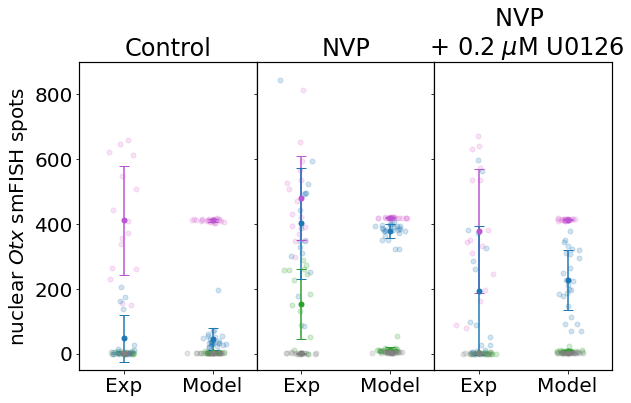

In [20]:
fig = plt.figure(figsize=(9,6))
gs = fig.add_gridspec(1,3, hspace=0,wspace=0)
axs = gs.subplots(sharey=True)

# control
x = np.random.normal(1, 0.08, size=len(control_a65 ))
axs[0].plot(x,control_a65 ,'.', color='orchid', alpha=0.2, markersize=10, zorder=1)

x = np.random.normal(1, 0.08, size=len(control_a66 ))
axs[0].plot(x,control_a66 ,'.', color='tab:green', alpha=0.2, markersize=10, zorder=1)

x = np.random.normal(1, 0.08, size=len(control_a68 ))
axs[0].plot(x,control_a68 ,'.', color='grey', alpha=0.2, markersize=10, zorder=1)

x = np.random.normal(1, 0.08, size=len(control_a67 ))
axs[0].plot(x,control_a67 ,'.', color='tab:blue', alpha=0.2, markersize=10, zorder=1)


x = np.random.normal(2, 0.08, size=len(Otx_pred_a65_sc))
axs[0].plot(x,Otx_pred_a65_sc,'.', color='orchid', alpha=0.2, markersize=10, zorder=1)

x = np.random.normal(2, 0.08, size=len(Otx_pred_a66_sc ))
axs[0].plot(x,Otx_pred_a66_sc ,'.', color='tab:green', alpha=0.2, markersize=10, zorder=1)

x = np.random.normal(2, 0.08, size=len(Otx_pred_a68_sc ))
axs[0].plot(x,Otx_pred_a68_sc ,'.', color='grey', alpha=0.2, markersize=10, zorder=1)

x = np.random.normal(2, 0.08, size=len(Otx_pred_a67_sc ))
axs[0].plot(x,Otx_pred_a67_sc ,'.', color='tab:blue', alpha=0.2, markersize=10, zorder=1)

ax= axs[0]
myErrorbar(x=[1], mean_a65= mean_control[0], mean_a66= mean_control[1], mean_a67=mean_control[2], mean_a68= mean_control[3], std_a65= std_control[0], std_a66= std_control[1], std_a67=std_control[2], std_a68=std_control[3], axs =ax)
myErrorbar(x=[2], mean_a65= mean_Otx_pred_a65_sc, mean_a66= mean_Otx_pred_a66_sc, mean_a67=mean_Otx_pred_a67_sc, mean_a68= mean_Otx_pred_a68_sc, std_a65= std_Otx_pred_a65_sc, std_a66= std_Otx_pred_a66_sc, std_a67=std_Otx_pred_a67_sc, std_a68=std_Otx_pred_a68_sc, axs =ax)
my_axsis(ax, xlim=[0.5,2.5], ylim=[-50,500], xticks=[1,2], title='Control', xtickslabels=['Exp', 'Model'])
ax.set_ylabel('nuclear $Otx$ smFISH spots')


# NVP
x = np.random.normal(1, 0.08, size=len(NVP_a65 ))
axs[1].plot(x,NVP_a65 ,'.', color='orchid', alpha=0.2, markersize=10, zorder=1)

x = np.random.normal(1, 0.08, size=len(NVP_a66 ))
axs[1].plot(x,NVP_a66 ,'.', color='tab:green', alpha=0.2, markersize=10, zorder=1)

x = np.random.normal(1, 0.08, size=len(NVP_a68 ))
axs[1].plot(x,NVP_a68 ,'.', color='grey', alpha=0.2, markersize=10, zorder=1)

x = np.random.normal(1, 0.08, size=len(NVP_a67 ))
axs[1].plot(x,NVP_a67 ,'.', color='tab:blue', alpha=0.2, markersize=10, zorder=1)


x = np.random.normal(2, 0.08, size=len(Otx_pred_a65_NVP_sc ))
axs[1].plot(x,Otx_pred_a65_NVP_sc ,'.', color='orchid', alpha=0.2, markersize=10, zorder=1)

x = np.random.normal(2, 0.08, size=len(Otx_pred_a66_NVP_sc ))
axs[1].plot(x,Otx_pred_a66_NVP_sc ,'.', color='tab:green', alpha=0.2, markersize=10, zorder=1)

x = np.random.normal(2, 0.08, size=len(Otx_pred_a68_NVP_sc ))
axs[1].plot(x,Otx_pred_a68_NVP_sc ,'.', color='grey', alpha=0.2, markersize=10, zorder=1)

x = np.random.normal(2, 0.08, size=len(Otx_pred_a67_NVP_sc ))
axs[1].plot(x,Otx_pred_a67_NVP_sc ,'.', color='tab:blue', alpha=0.2, markersize=10, zorder=1)

ax= axs[1]
myErrorbar(x=[1], mean_a65= mean_NVP[0], mean_a66= mean_NVP[1], mean_a67=mean_NVP[2], mean_a68= mean_NVP[3], std_a65= std_NVP[0], std_a66= std_NVP[1], std_a67=std_NVP[2], std_a68=std_NVP[3], axs =ax)
myErrorbar(x=[2], mean_a65= mean_Otx_pred_a65_NVP_sc, mean_a66= mean_Otx_pred_a66_NVP_sc, mean_a67=mean_Otx_pred_a67_NVP_sc, mean_a68= mean_Otx_pred_a68_NVP_sc, std_a65= std_Otx_pred_a65_NVP_sc, std_a66= std_Otx_pred_a66_NVP_sc, std_a67=std_Otx_pred_a67_NVP_sc, std_a68=std_Otx_pred_a68_NVP_sc, axs =ax)
my_axsis(ax, xlim=[0.5,2.5], ylim=[-50,500], xticks=[1,2], title='NVP', xtickslabels=['Exp', 'Model'])


# NVP+U0126
x = np.random.normal(1, 0.08, size=len(Rescue_a65 ))
axs[2].plot(x,Rescue_a65 ,'.', color='orchid', alpha=0.2, markersize=10, zorder=1)

x = np.random.normal(1, 0.08, size=len(Rescue_a66 ))
axs[2].plot(x,Rescue_a66 ,'.', color='tab:green', alpha=0.2, markersize=10, zorder=1)

x = np.random.normal(1, 0.08, size=len(Rescue_a68 ))
axs[2].plot(x,Rescue_a68 ,'.', color='grey', alpha=0.2, markersize=10, zorder=1)

x = np.random.normal(1, 0.08, size=len(Rescue_a67 ))
axs[2].plot(x,Rescue_a67 ,'.', color='tab:blue', alpha=0.2, markersize=10, zorder=1)


x = np.random.normal(2, 0.08, size=len(Otx_pred_a65_Rescue_sc ))
axs[2].plot(x,Otx_pred_a65_Rescue_sc ,'.', color='orchid', alpha=0.2, markersize=10, zorder=1)

x = np.random.normal(2, 0.08, size=len(Otx_pred_a66_Rescue_sc ))
axs[2].plot(x,Otx_pred_a66_Rescue_sc ,'.', color='tab:green', alpha=0.2, markersize=10, zorder=1)

x = np.random.normal(2, 0.08, size=len(Otx_pred_a68_Rescue_sc ))
axs[2].plot(x,Otx_pred_a68_Rescue_sc ,'.', color='grey', alpha=0.2, markersize=10, zorder=1)

x = np.random.normal(2, 0.08, size=len(Otx_pred_a67_Rescue_sc ))
axs[2].plot(x,Otx_pred_a67_Rescue_sc ,'.', color='tab:blue', alpha=0.2, markersize=10, zorder=1)

ax= axs[2]
myErrorbar(x=[1], mean_a65= mean_Rescue[0], mean_a66= mean_Rescue[1], mean_a67=mean_Rescue[2], mean_a68= mean_Rescue[3], std_a65= std_Rescue[0], std_a66= std_Rescue[1], std_a67=std_Rescue[2], std_a68=std_Rescue[3], axs =ax)
myErrorbar(x=[2], mean_a65= mean_Otx_pred_a65_Rescue_sc, mean_a66= mean_Otx_pred_a66_Rescue_sc, mean_a67=mean_Otx_pred_a67_Rescue_sc, mean_a68= mean_Otx_pred_a68_Rescue_sc, std_a65= std_Otx_pred_a65_Rescue_sc, std_a66= std_Otx_pred_a66_Rescue_sc, std_a67=std_Otx_pred_a67_Rescue_sc, std_a68=std_Otx_pred_a68_Rescue_sc, axs =ax)
my_axsis(ax, xlim=[0.5,2.5], ylim=[-50,900], xticks=[1,2], title='NVP \n + 0.2 $\mu$M U0126', xtickslabels=['Exp', 'Model'])

plt.tight_layout()
plt.show()

## Figure S4B

#### NVP

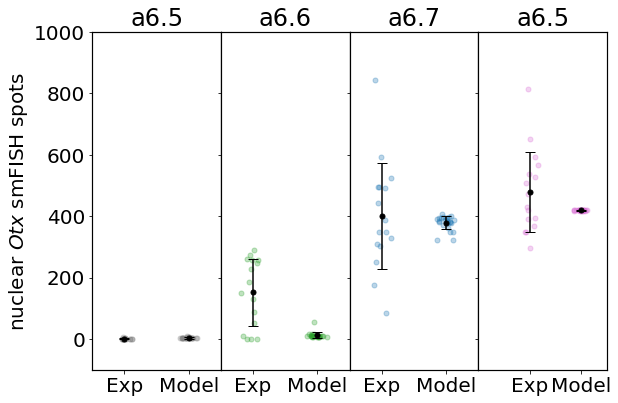

In [21]:
fig = plt.figure(figsize=(9,6))
gs = fig.add_gridspec(1,4, hspace=0,wspace=0)
axs = gs.subplots(sharey=True)

# a6.8
x = np.random.normal(1, 0.08, size=len(NVP_a68))
axs[0].plot(x,NVP_a68,'.', color='grey', alpha=0.3, markersize=10,zorder=1)
 
axs[0].errorbar(1,mean_NVP[3] ,std_NVP[3], marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

x = np.random.normal(2, 0.08, size=len(Otx_pred_a68_NVP_sc))
axs[0].plot(x,Otx_pred_a68_NVP_sc,'.', color='grey', alpha=0.3, markersize=10,zorder=1)

axs[0].errorbar(2,mean_Otx_pred_a68_NVP_sc ,std_Otx_pred_a68_NVP_sc, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

my_axsis(axs[0], xlim= [0.5,2.5], ylim=[-100,1000], xticks=[1,2], title='a6.5', xtickslabels=['Exp', 'Model'], bold=True)
axs[0].set_ylabel('nuclear $Otx$ smFISH spots')


# a6.6 
x = np.random.normal(1, 0.08, size=len(NVP_a66))
axs[1].plot(x,NVP_a66,'.', color='tab:green', alpha=0.3, markersize=10, zorder=1)

x = 1 
axs[1].errorbar(x,mean_NVP[1] ,std_NVP[1], marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

x = np.random.normal(2, 0.08, size=len(Otx_pred_a66_NVP_sc))
axs[1].plot(x,Otx_pred_a66_NVP_sc,'.', color='tab:green', alpha=0.3, markersize=10, zorder=1)

x = 2 
axs[1].errorbar(x,mean_Otx_pred_a66_NVP_sc ,std_Otx_pred_a66_NVP_sc, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

my_axsis(axs[1], xlim= [0.5,2.5], ylim=[-100,1000], xticks=[1,2], title='a6.6', xtickslabels=['Exp', 'Model'], bold=True)


# a6.7 
x = np.random.normal(1, 0.08, size=len(NVP_a67))
axs[2].plot(x,NVP_a67,'.', color='tab:blue', alpha=0.3, markersize=10, zorder=1)
 
axs[2].errorbar(1,mean_NVP[2], std_NVP[2], marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

x = np.random.normal(2, 0.08, size=len(Otx_pred_a67_NVP_sc))
axs[2].plot(x,Otx_pred_a67_NVP_sc,'.', color='tab:blue', alpha=0.3, markersize=10, zorder=1)

axs[2].errorbar(2,mean_Otx_pred_a67_NVP_sc,std_Otx_pred_a67_NVP_sc, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

my_axsis(axs[2], xlim= [0.5,2.5], ylim=[-100,1000], xticks=[1,2], title='a6.7', xtickslabels=['Exp', 'Model'], bold=True)


# a6.5
x = np.random.normal(1, 0.08, size=len(NVP_a65))
axs[3].plot(x,NVP_a65,'.', color='orchid', alpha=0.3,zorder=1, markersize=10)
 
axs[3].errorbar(1,mean_NVP[0], std_NVP[0], marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

x = np.random.normal(2, 0.08, size=len(Otx_pred_a65_NVP_sc))
axs[3].plot(x,Otx_pred_a65_NVP_sc,'.', color='orchid', alpha=0.3,zorder=1, markersize=10)

axs[3].errorbar(2,mean_Otx_pred_a65_NVP_sc, std_Otx_pred_a65_NVP_sc, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

my_axsis(axs[3], xlim= [0,2.5], ylim=[-100,1000], xticks=[1,2], title='a6.5', xtickslabels=['Exp', 'Model'], bold=True)

plt.tight_layout()
plt.show()

#### NVP +U0126

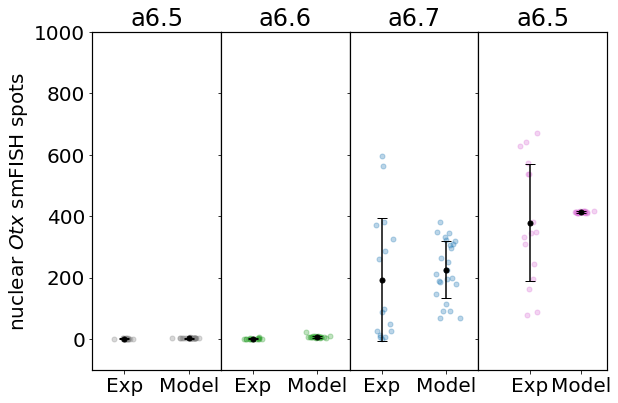

In [22]:
fig = plt.figure(figsize=(9,6))
gs = fig.add_gridspec(1,4, hspace=0,wspace=0)
axs = gs.subplots(sharey=True)

# a6.8
x = np.random.normal(1, 0.08, size=len(Rescue_a68))
axs[0].plot(x,Rescue_a68,'.', color='grey', alpha=0.3, markersize=10,zorder=1)
 
axs[0].errorbar(1,mean_Rescue[3] ,std_Rescue[3], marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

x = np.random.normal(2, 0.08, size=len(Otx_pred_a68_Rescue_sc))
axs[0].plot(x,Otx_pred_a68_Rescue_sc,'.', color='grey', alpha=0.3, markersize=10,zorder=1)

axs[0].errorbar(2,mean_Otx_pred_a68_Rescue_sc ,std_Otx_pred_a68_Rescue_sc, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

my_axsis(axs[0], xlim= [0.5,2.5], ylim=[-100,1000], xticks=[1,2], title='a6.5', xtickslabels=['Exp', 'Model'], bold=True)
axs[0].set_ylabel('nuclear $Otx$ smFISH spots')


# a6.6 
x = np.random.normal(1, 0.08, size=len(Rescue_a66))
axs[1].plot(x,Rescue_a66,'.', color='tab:green', alpha=0.3, markersize=10, zorder=1)

x = 1 
axs[1].errorbar(x,mean_Rescue[1] ,std_Rescue[1], marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

x = np.random.normal(2, 0.08, size=len(Otx_pred_a66_Rescue_sc))
axs[1].plot(x,Otx_pred_a66_Rescue_sc,'.', color='tab:green', alpha=0.3, markersize=10, zorder=1)

x = 2 
axs[1].errorbar(x,mean_Otx_pred_a66_Rescue_sc ,std_Otx_pred_a66_Rescue_sc, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

my_axsis(axs[1], xlim= [0.5,2.5], ylim=[-100,1000], xticks=[1,2], title='a6.6', xtickslabels=['Exp', 'Model'], bold=True)


# a6.7 
x = np.random.normal(1, 0.08, size=len(Rescue_a67))
axs[2].plot(x,Rescue_a67,'.', color='tab:blue', alpha=0.3, markersize=10, zorder=1)
 
axs[2].errorbar(1,mean_Rescue[2], std_Rescue[2], marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

x = np.random.normal(2, 0.08, size=len(Otx_pred_a67_Rescue_sc))
axs[2].plot(x,Otx_pred_a67_Rescue_sc,'.', color='tab:blue', alpha=0.3, markersize=10, zorder=1)

axs[2].errorbar(2,mean_Otx_pred_a67_Rescue_sc,std_Otx_pred_a67_Rescue_sc, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

my_axsis(axs[2], xlim= [0.5,2.5], ylim=[-100,1000], xticks=[1,2], title='a6.7', xtickslabels=['Exp', 'Model'], bold=True)


# a6.5
x = np.random.normal(1, 0.08, size=len(Rescue_a65))
axs[3].plot(x,Rescue_a65,'.', color='orchid', alpha=0.3,zorder=1, markersize=10)
 
axs[3].errorbar(1,mean_Rescue[0], std_Rescue[0], marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

x = np.random.normal(2, 0.08, size=len(Otx_pred_a65_Rescue_sc))
axs[3].plot(x,Otx_pred_a65_Rescue_sc,'.', color='orchid', alpha=0.3,zorder=1, markersize=10)

axs[3].errorbar(2,mean_Otx_pred_a65_Rescue_sc, std_Otx_pred_a65_Rescue_sc, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

my_axsis(axs[3], xlim= [0,2.5], ylim=[-100,1000], xticks=[1,2], title='a6.5', xtickslabels=['Exp', 'Model'], bold=True)

plt.tight_layout()
plt.show()